In [1]:
%load_ext autoreload
%autoreload 2

import RockPy3

RockPy3.logger.setLevel('ERROR')
from scipy.interpolate import interp1d
from scipy import stats
%pylab inline
from copy import deepcopy
#RockPy3.setLatex(False)
close('all')

INFO     RockPy3         RockPy3 rocks! Git repository version: b'17eaab6-dirty'
INFO     RockPy3         RockPy3 test_data_path: /Users/mike/GitHub/highT_af/RockPy3/testing/test_data
INFO     RockPy3         RockPy3 installation_directory: /Users/mike/Google Drive/__code/RockPy3
INFO     RockPy3         using matplotlib  : version 1.5.1
INFO     RockPy3         using numpy       : version 1.11.1
INFO     RockPy3         using scipy       : version 0.17.1
INFO     RockPy3         using lmfit       : version 0.9.5
INFO     RockPy3         using pint        : version 0.7.2
INFO     RockPy3         using decorator   : version 4.0.10
INFO     RockPy3         using tabulate    : version 0.7.5
ERROR    RockPy3         please install basemap
INFO     RockPy3         CREATING study << MasterStudy >>


IMPLEMENTED MEASUREMENT TYPES     : 	FTYPES
---------------------------------------------------------------------------
	acquisition               : 	jr6, sushibar
	afdemagnetization         : 	jr6, sushibar, cryomag
	arm_acquisition           : 	jr6, sushibar
	backfield                 : 	vftb, vsm
	bedding                   : 	generic
	demagnetization           : 	jr6, sushibar, cryomag
	diameter                  : 	generic
	height                    : 	generic
	htarm_acquisition         : 	jr6, sushibar
	hysteresis                : 	vftb, mpms, vsm
	irm_acquisition           : 	jr6, sushibar, vsm
	length                    : 	generic
	locationgeo               : 	generic
	mass                      : 	generic
	orientationgeo            : 	generic
	paleointensity            : 	
	parameter                 : 	
	parm_acquisition          : 	jr6, sushibar
	thermaldemagnetization    : 	jr6, sushibar, cryomag
	thermocurve               : 	vftb, mpms, vsm
	trm_acquisition           : 	jr6, s

# AF demagnetization and ARM acquisition at elevated tempertures in natural titanomagnetites
## Figure and calculations

In [2]:
# these are the different files 
fhybrid = '/Users/mike/GitHub/highT_af/High_T_ARM_hTARMACQUISITION_50uT.jr6.txt'
farm = '/Users/mike/GitHub/highT_af/High_T_ARM_ARMACQUISITION_50uT.jr6.txt'
ftrm = '/Users/mike/GitHub/highT_af/High_T_ARM_TRMACQUISITION_50uT.jr6.txt'

In [3]:
# this is where the figures will be stored
figure_folder = '/Users/mike/Dropbox/PHD/006_HT-ARM-AF/figures' # for analysis
paper_folder = '/Users/mike/GitHub/writing/working paper/HighTempAF' # for publication

In [4]:
#importing all the data

S = RockPy3.RockPyStudy()
for sname in ['Va', 'Vb', 'IXD', '525', '1125', '1524']:
    s = S.add_sample(name=sname)
    if sname in ['Va', 'Vb', 'IXD']:
        s.add_to_samplegroup(gname='obs')
    if sname in ['525', '1125', '1524']:
        s.add_to_samplegroup(gname='mani')
    
    hyb = s.add_measurement(mtype='acquisition', ftype='jr6', fpath=fhybrid)
    hyb.add_series('HTARM')
    trm = s.add_measurement(mtype='acquisition', ftype='jr6', fpath=ftrm)
    trm.add_series('TRM')
    arm = s.add_measurement(mtype='acquisition', ftype='jr6', fpath=farm)
    arm.add_series('ARM')

### Correction of temperature data for Va/Vb
Temperature for the last samples has to be corrected. They showed behavior as if they had not reached the set temperature.

In [5]:
# correct Va temperatures by 0.85
for m in S['Va'].get_measurement(mtype='acquisition'):
    m.data['data']['variable'] = m.data['data']['variable'].v *0.85

# correct Va temperatures by 0.9
for m in S['Vb'].get_measurement(mtype='acquisition'):
    m.data['data']['variable'] = m.data['data']['variable'].v *0.9

In [6]:
VaVbARM = '/Users/mike/GitHub/highT_af/High_T_ARM_ARMACQUISITION_50uT_VA_VB.jr6'
VaVbTRM = '/Users/mike/GitHub/highT_af/High_T_ARM_TRMACQUISITION_50uT_VA_VB.jr6'
VaVbhTARM = '/Users/mike/GitHub/highT_af/High_T_ARM_hTARMACQUISITION_50uT_VA_VB.jr6'

for i, f in enumerate((VaVbARM, VaVbTRM, VaVbhTARM)):
    m1 = S['Va'].add_measurement(fpath=f, mtype='acquisition', ftype='jr6')
    m2 = S['Vb'].add_measurement(fpath=f, mtype='acquisition', ftype='jr6')
    if i == 0:
        stype = 'ARM'
    if i == 1:
        stype = 'TRM'
    if i == 2:
        stype = 'HTARM'
    for m in (m1,m2):
        m.add_series(stype)

In [7]:
for s in ('Va', 'Vb'):
    arms = S[s].get_measurement(stype='arm')
    trms = S[s].get_measurement(stype='trm')
    htarms = S[s].get_measurement(stype='htarm')
    arms[0].combine_measurements(arms[1:], remove_others = True)
    trms[0].combine_measurements(trms[1:], remove_others = True)
    htarms[0].combine_measurements(htarms[1:], remove_others = True)

### calculating the theoretical sum/differences for TRM-ARM

In [8]:
for s in S:
    arm = s.get_measurement(stype='arm')[0]
    trm = s.get_measurement(stype='trm')[0]
    hyb = s.get_measurement(stype='htarm')[0]
    tarm = arm + trm
    tarm.add_series('T+ARM')
    harm = hyb - trm
    harm.add_series('H-TRM')
    htrm = hyb - arm
    htrm.add_series('H-ARM')

In [9]:
S.info()

20161108:1611
------------------  ----------------------------------------------
6 samples           1125,1524,525,IXD,Va,Vb
------------------  ----------------------------------------------
36 measurements     acquisition
                    6 series:
                    arm: 0.0[6]
                    h-arm: 0.0[6]
                    h-trm: 0.0[6]
                    htarm: 0.0[6]
                    t+arm: 0.0[6]
                    trm: 0.0[6]
------------------  ----------------------------------------------

Sample Name      Sample Group     Measurements       series                                              Initial State
---------------  ---------------  -----------------  --------------------------------------------------  ---------------
1125             ['mani']         6x acquisition     {'arm', 'h-trm', 't+arm', 'htarm', 'h-arm', 'trm'}  False
===============  ===============  ===============    ===============                                     ===============
      

## Figures

Here are the TRM, ARM, and hTARM acquisition curves for the samples

### Obsidian

True
True
True


/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


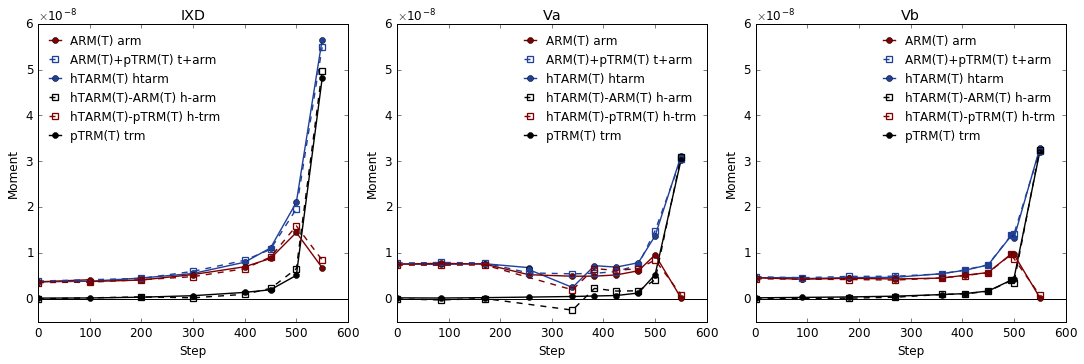

In [74]:
S.label_add_series(add_sval=False, add_unit=False)
f = RockPy3.Figure()
for s in S['obs']:
    v = f.add_visual('acquisition', data=s, component='z')
    v.title = s.name
f.show(equal_lims=True, save_path=figure_folder, file_name='OBS_acquisition_corrected.pdf')

In [ ]:
S.label_add_series(add_sval=False, add_unit=False)
f = RockPy3.Figure()
for s in S['mani']:
    v = f.add_visual('acquisition', data=s, component='z')
    v.title = s.name
f.show(equal_lims=True, save_path=figure_folder, file_name='MAN_acquisition_corrected.pdf')

## High Temperature AF

In [11]:
for s in S:

    m = s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AFdemag_020.jr6',
                          mtype='afdemag', ftype='jr6', series=[('at', 0, 'C'), ('post', 0, 'C')])
    #s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AF-demag_020_TRM.jr6',
    #                      mtype='af', ftype='jr6')
        
    #s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AF-demag_300_TRM.jr6',
    #                      mtype='af', ftype='jr6')
    m = s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AFdemag_300.jr6',
                          mtype='af', ftype='jr6', series=[('at', 300, 'C'), ('post', 300, 'C')])    
    #s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AF-demag_500_TRM.jr6',
    #                      mtype='af', ftype='jr6')    
    m = s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AFdemag_500.jr6',
                          mtype='af', ftype='jr6', series=[('at', 500, 'C'), ('post', 500, 'C')])    
    #s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AF-demag_TH300_TRM.jr6',
    #                      mtype='af', ftype='jr6')    
    m = s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AFdemag_TH300.jr6',
                          mtype='af', ftype='jr6', series=[('at', 0, 'C'), ('post', 300, 'C')])    
    #s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AF-demag_TH500_TRM.jr6',
    #                      mtype='af', ftype='jr6')    
    m = s.add_measurement(fpath='/Users/mike/Dropbox/experimental_data/006_HT-ARM-AF/AF/High_T_AFdemag_TH500.jr6',
                          mtype='af', ftype='jr6', series=[('at', 0, 'C'), ('post', 500, 'C')])    


/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/Users/mike/anaconda/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empt

In [12]:
S.reset_plt_prop()

In [13]:
# redefining the colors and linestyles for the figure
for s in S.samplelist:
    for m in s.get_measurement():
        m.set_plt_prop('linewidth', 1.4)
        if m.has_stype(['trm', 'h-arm'], 'any'):
            m.set_plt_prop('color', RockPy3.colorscheme[0])
            if m.has_stype(['trm'],'any'):
                    m.set_plt_prop('label', 'pTRM(T)')
            if m.has_stype(['h-arm'],'any'):
                    m.set_plt_prop('label', 'hTARM(T)-ARM(T)')
        elif m.has_stype(['arm', 'h-trm'],'any'):
            m.set_plt_prop('color', RockPy3.colorscheme[1])
            if m.has_stype(['arm'],'any'):
                m.set_plt_prop('label', 'ARM(T)')                
            if m.has_stype(['h-trm'],'any'):
                m.set_plt_prop('label', 'hTARM(T)-pTRM(T)')
        elif m.has_stype(['htarm', 't+arm'],'any'):
            m.set_plt_prop('color', RockPy3.colorscheme[8])
            if m.has_stype(['htarm'],'any'):
                m.set_plt_prop('label', 'hTARM(T)')
            if m.has_stype(['t+arm'],'any'):
                m.set_plt_prop('label', 'ARM(T)+pTRM(T)')
        if m.has_stype(['h-trm', 't+arm', 'h-arm'],'any'):
            m.set_plt_prop('marker', 's')
            m.set_plt_prop('markerfacecolor', 'None')
            m.set_plt_prop('markeredgewidth', 1.3)
            m.set_plt_prop('markeredgecolor', m.plt_props['color'])

            m.set_plt_prop('linestyle', '--')
        else:
            m.set_plt_prop('marker', 'o')

In [14]:
close('all')

/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


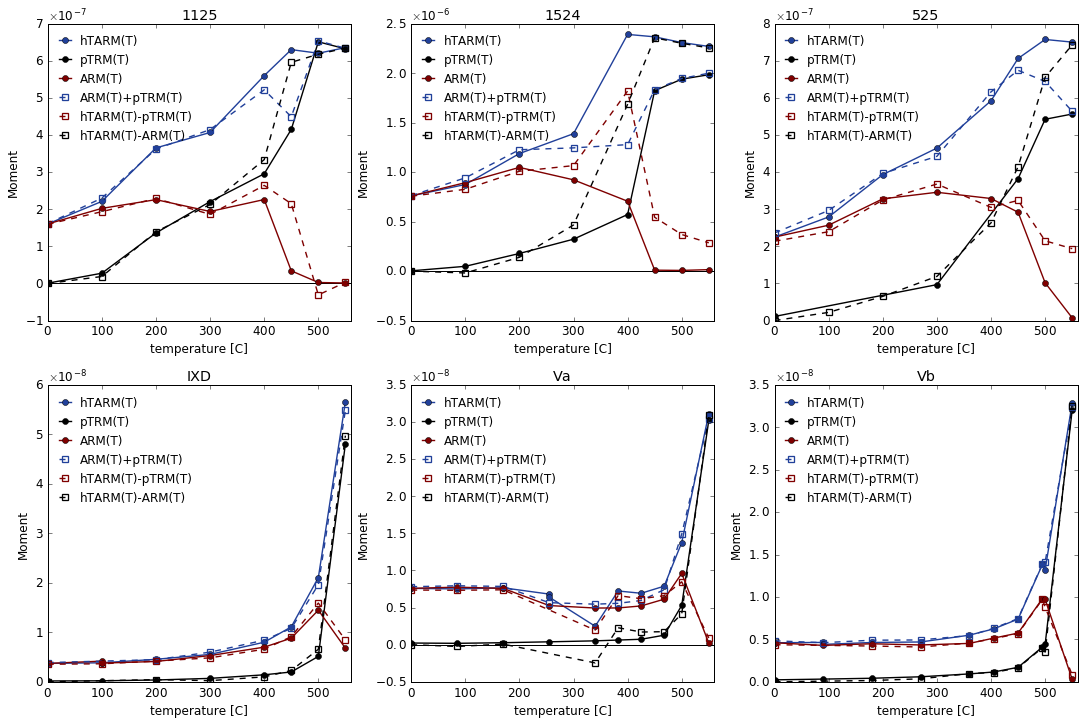

In [39]:
f = RockPy3.Figure()
for s in S:
    v = f.add_visual('acquisition', data=s)
    v.title = s.name
    v.xlabel='temperature [C]'
f.show(xlim=(0,560), save_path=figure_folder, file_name='ARM(T),TRM(T),hATRM(T)_ALL', sort_labels=False)

/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


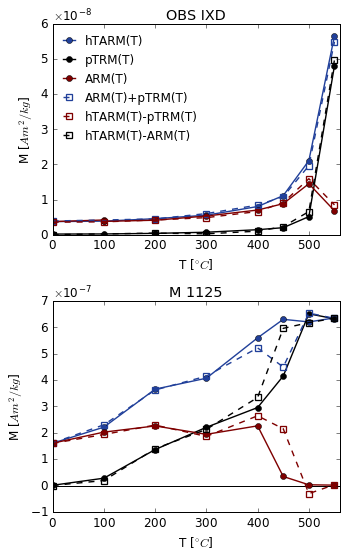

In [37]:
RockPy3.set_fontsize(12)
f = RockPy3.Figure(figsize=(9.5/2, 11.5/3), columns=1)

#Obsidian Sample
v = f.add_visual('acquisition', data=S['IXD'])
v.title = 'OBS IXD'
v.xlabel='T [$^{\circ} C$]'
v.ylabel='M [$Am^2/kg$]'
v.legend['fontsize']= 12

# Manicouagan Sample
v = f.add_visual('acquisition', data=S['1125'])
v.title = 'M 1125'
v.xlabel='T [$^{\circ} C$]'
v.ylabel='M [$Am^2/kg$]'
v.remove_labels()

f.show(xlim=(0,560), save_path=paper_folder, file_name='fig02_acquisition.pdf', sort_labels=False, equal_lims=False)


# AF plots
AF(0,0) = Af demagnetization at room temperatre after thermal demagnetization at room temperature

AF(0,300) = Af demagnetization at room temperatre after thermal demagnetization at 300C

...

In [19]:
# # redefining the colors and linestyles for the figure
# for s in S.samplelist:
#     for m in s.get_measurement():
#         m.set_plt_prop('linewidth', 1.4)
#         if m.has_stype(['trm', 'h-arm'], 'any'):
#             m.set_plt_prop('color', RockPy3.colorscheme[0])
#             if m.has_stype(['trm'],'any'):
#                     m.set_plt_prop('label', 'pTRM(T)')
#             if m.has_stype(['h-arm'],'any'):
#                     m.set_plt_prop('label', 'hTARM(T)-ARM(T)')
#         elif m.has_stype(['arm', 'h-trm'],'any'):
#             m.set_plt_prop('color', RockPy3.colorscheme[1])
#             if m.has_stype(['arm'],'any'):
#                 m.set_plt_prop('label', 'ARM(T)')                
#             if m.has_stype(['h-trm'],'any'):
#                 m.set_plt_prop('label', 'hTARM(T)-pTRM(T)')
#         elif m.has_stype(['htarm', 't+arm'],'any'):
#             m.set_plt_prop('color', RockPy3.colorscheme[8])
#             if m.has_stype(['htarm'],'any'):
#                 m.set_plt_prop('label', 'hTARM(T)')
#             if m.has_stype(['t+arm'],'any'):
#                 m.set_plt_prop('label', 'ARM(T)+pTRM(T)')
#         if m.has_stype(['h-trm', 't+arm', 'h-arm'],'any'):
#             m.set_plt_prop('marker', 's')
#             m.set_plt_prop('markerfacecolor', 'None')
#             m.set_plt_prop('markeredgewidth', 1.3)
#             m.set_plt_prop('markeredgecolor', m.plt_props['color'])

#             m.set_plt_prop('linestyle', '--')
#         else:
#             m.set_plt_prop('marker', 'o')

In [40]:
for m in S.get_measurement(mtype='afdemagnetization'):
        series = (m.get_series('at')[0].v, m.get_series('post')[0].v)
        if series[0] == 0:
            m.set_plt_prop('linestyle', '--')
        if series[1] == 0:
            m.set_plt_prop('color', RockPy3.colorscheme[0])
        if series[1] == 300:
            m.set_plt_prop('color', RockPy3.colorscheme[1])
        if series[1] == 500:
            m.set_plt_prop('color', RockPy3.colorscheme[8])
        m.plt_props['label']= 'AF({}, {})'.format(*series)

/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


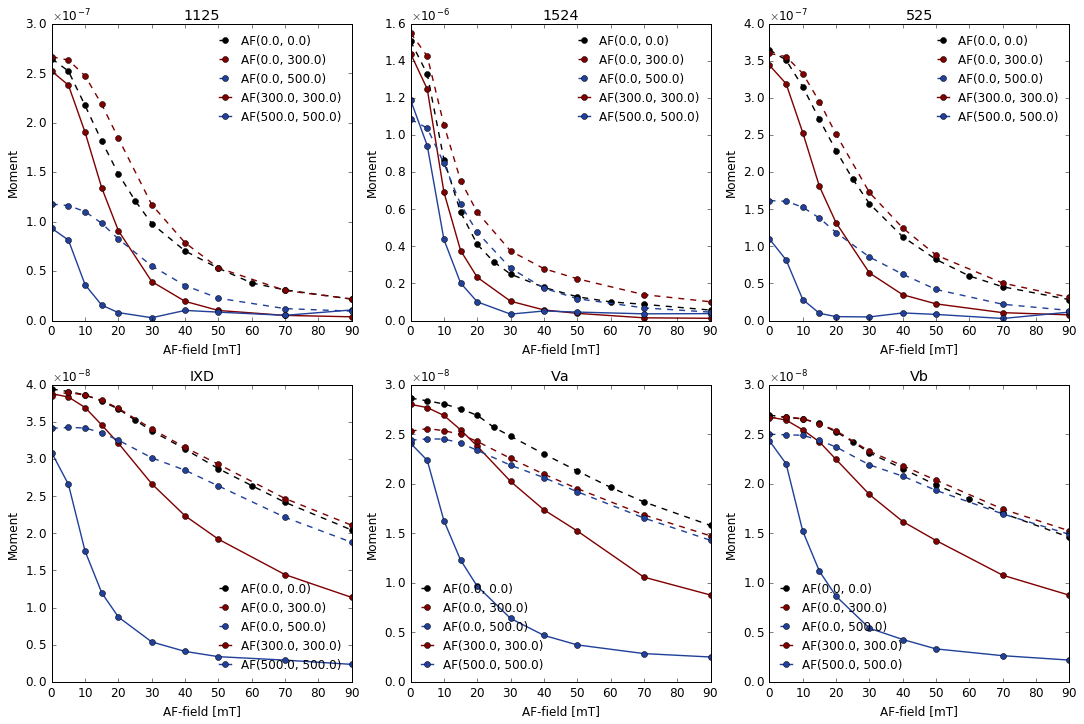

In [41]:
f = RockPy3.Figure(marker='o', columns=3)
for s in S:
    v = f.add_visual('demagnetization', data = s)
    v.title=s.name
    v.xlabel='AF-field [mT]'
f.show(xlim=(0,90), save_path=figure_folder, file_name='AF(0-500,0-500)(ALL)')

/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


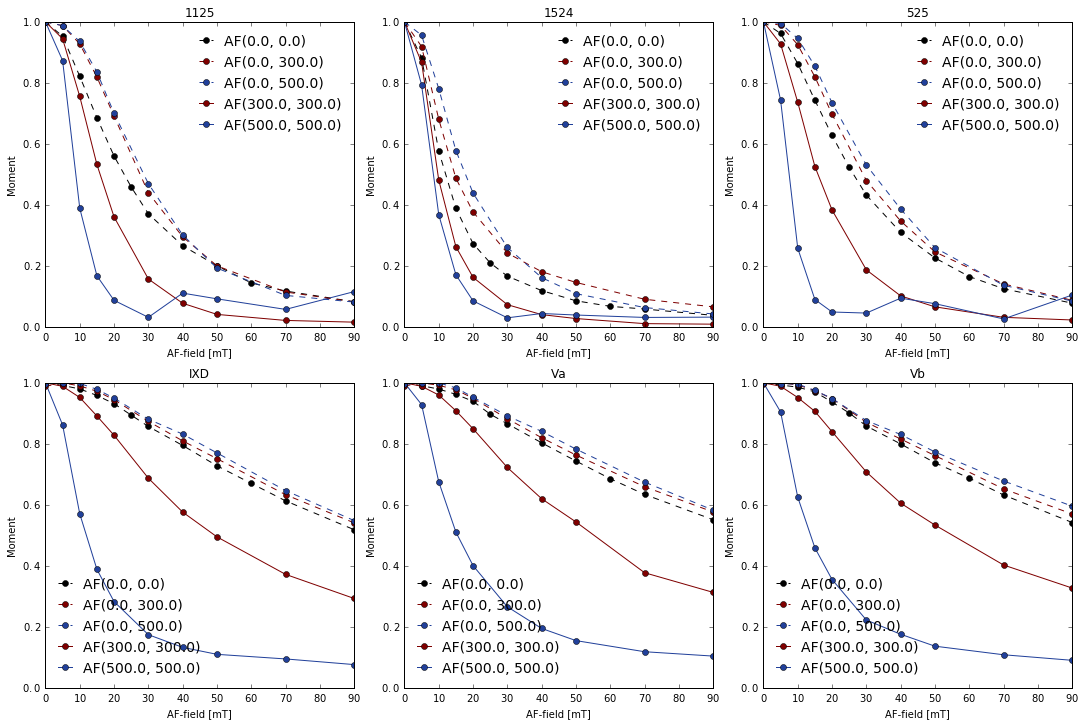

In [24]:
f = RockPy3.Figure(marker='o', columns=3)
for s in S:
    v = f.add_visual('demagnetization', data = s)
    v.normalize(vval=0)
    v.title=s.name
    v.xlabel='AF-field [mT]'
f.show(xlim=(0,90), save_path=figure_folder, file_name='AF(0-500,0-500)(ALL)_norm')

showing legend: False
True


/Users/mike/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


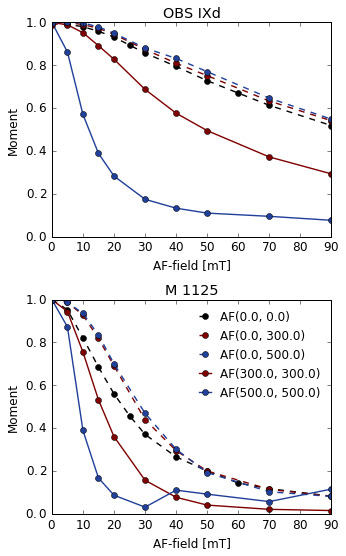

In [73]:
f = RockPy3.Figure(marker='o', figsize=(9.5/2, 11.5/3), columns=1)
v = f.add_visual('demagnetization', data=S['IXD'])
v.show_legend(False)
v.title = 'OBS IXd'
v.xlabel='AF-field [mT]'
v.normalize(vval=0)

v = f.add_visual('demagnetization', data=S['1125'])
v.title = 'M 1125'
v.xlabel='AF-field [mT]'
v.normalize(vval=0)

f.show(xlim=(0,90), save_path=paper_folder, file_name='fig01_af_demag.pdf')

## fitting x% of m @ B(mt) 

In [26]:
data = {}
#vars = np.arange(1,0.2,-0.1)

for s in S:
    d = {}
    for t in (300, 500):
        aux = [None, None]
        mlist = s.get_measurement('af', sval=t)
        m0 = [m for m in mlist if m.has_series(series=('at', 0))][0]
        m0.normalize()
        vars = m0.data['data']['mag'].v
        mt = [m for m in mlist if m.has_series(series=('at', t))][0]
        mt.normalize()

        x = mt.data['data']['mag'].v
        y = mt.data['data']['field'].v
        f = interp1d(x, y, bounds_error=False, kind='slinear')
        
        x0 = m0.data['data']['mag'].v
        y0 = m0.data['data']['field'].v
        f0 = interp1d(x0, y0, bounds_error=False, kind='slinear')
        aux = (np.array(list(zip(f0(vars), vars))), np.array(list(zip(f(vars), vars))))
#        if s.name == 'IXD': print(aux)

        d[t] = np.array(aux)
    data[s.name]= d

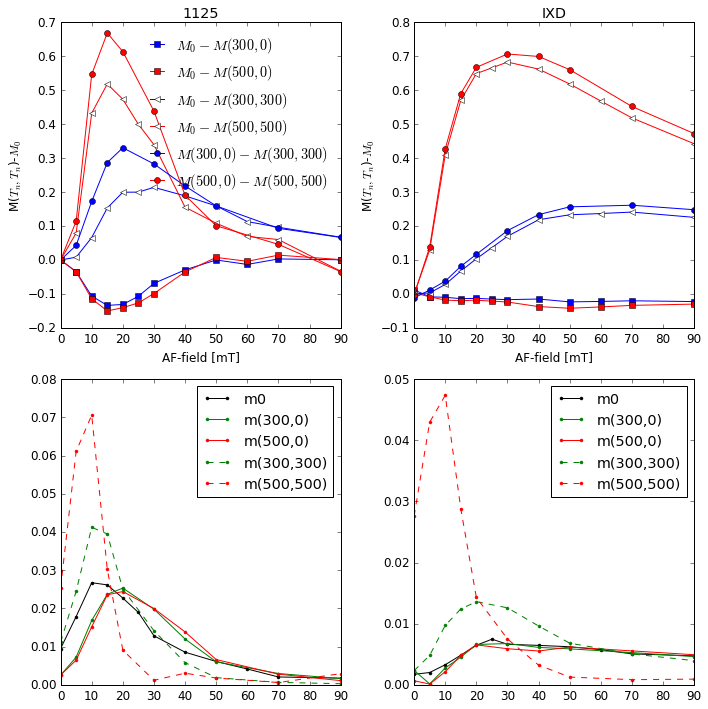

In [75]:

S.normalize(reference='data', vval=0)
f, axes = subplots(2,2, figsize=(10,10))
axes = axes.flatten()
colors = ('k', 'g', 'r', 'g', 'r')
lines = ('-','-','-','--','--')
for i, s in enumerate(sorted(S.get_sample(sname=('IXD', '1125')))):

    ax = axes[i]
    m0 = s.get_measurement(series=[('at', 0), ('post',0)])[0]
    m300_0 = s.get_measurement(series=[('at', 0), ('post',300)])[0]
    m300_0 = s.get_measurement(series=[('at', 0), ('post',300)])[0]
    m300 = s.get_measurement(series=('at', 300))[0]

    m500_0 = s.get_measurement(series=[('at', 0), ('post',500)])[0]
    m500 = s.get_measurement(series=('at', 500))[0]
    
    dm0300 = m0-m300
    dm0500 =  m0-m500
    dm0300_0 =  m0-m300_0
    dm0500_0 = m0-m500_0
    dm300 = m300_0-m300
    dm500 = m500_0-m500

    # thermal demag data at Tr - Tr data
    # zeigt coercivity spektrum der demagnetisierten teile
    ax.plot(dm0300_0.data['data']['variable'].v, dm0300_0.data['data']['mag'].v, 'bs-', label='$M_0-M(300,0)$')
    ax.plot(dm0500_0.data['data']['variable'].v, dm0500_0.data['data']['mag'].v, 'rs-', label='$M_0-M(500,0)$')

    # demag at temperature Tn - Tr data
    # zeigt 
    ax.plot(dm0300.data['data']['variable'].v, dm0300.data['data']['mag'].v, 'b<-', mfc='w', label='$M_0-M(300,300)$')
    ax.plot(dm0500.data['data']['variable'].v, dm0500.data['data']['mag'].v, 'r<-', mfc='w', label='$M_0-M(500,500)$')

    ax.plot(dm300.data['data']['variable'].v, dm300.data['data']['mag'].v, 'bo-', label='$M(300,0)-M(300,300)$')
    ax.plot(dm500.data['data']['variable'].v, dm500.data['data']['mag'].v, 'ro-', label='$M(500,0)-M(500,500)$')
    labels = ('m0', 'm(300,0)','m(500,0)', 'm(300,300)', 'm(500,500)')
    for n, m in enumerate((m0, m300_0, m500_0, m300, m500)):
        x, y = (m.data['data']['variable'].v, m.data['data']['mag'].v)
        dx = np.gradient(x)
        dy = abs(np.gradient(y, dx))
        axes[i+2].plot(x,dy, color=colors[n], ls=lines[n], marker='.', label=labels[n])
        axes[i+2].legend(loc='best')
    ax.set_ylabel('M($T_n, T_n$)-$M_0$',)
    ax.set_xlabel("AF-field [mT]")
    ax.set_title(s.name)
axes[0].legend(loc='best', frameon=False, numpoints=1, handlelength=1)
tight_layout()


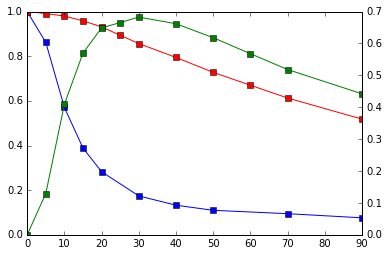

In [29]:
m2 = m500
plot(m2.data['data']['variable'].v, m2.data['data']['mag'].v, 'bs-', label='$M(300,0)$')
plot(m0.data['data']['variable'].v, m0.data['data']['mag'].v, 'rs-', label='$M(0,0)$')
f = interp1d(m2.data['data']['variable'].v, m2.data['data']['mag'].v)
gca().twinx().plot(m0.data['data']['variable'].v, m0.data['data']['mag'].v-f(m0.data['data']['variable'].v), 'gs-', label='$M(0,0)$')

525 : 2 last points too noisy

'Vb', 'IXD', '1125': last point strange

In [ ]:
close('all')

In [ ]:
import gc
gc.collect()
fig, axes = subplots(2,3, figsize=(10,10))
slopes = []
axes = axes.flatten()
samples = ['525', '1125', '1524', 'IXD', 'Va', 'Vb']
    
for sname, d in sorted(data.items()):
    i = samples.index(sname)
    for v in (300, 500):
        aux = []
        if v == 300:
            marker = 'o'
        else: marker = 's'
        line, = axes[i].plot(d[v][0][:,0], d[v][1][:,0], marker = marker, ls='',
                             label='%i °C'%v, color=RockPy3.colorscheme[S.samplenames.index(sname)])
        xy = list(zip(d[v][0][1:,0], d[v][1][1:,0]))
        vals = [round(1-n*0.1,1) for n, v in enumerate(xy) if not np.isnan(v[0]) if not np.isnan(v[1])]

        if sname in ('525', '1125', '1524'):
            xy = xy[:-2]
        xy = [d for d in xy if not np.isnan(d[0]) if not np.isnan(d[1])]
        slope, intercept, r_value, p_value, std_err = stats.linregress(xy)
        aux.append((sname, v, slope, 1/slope, 1/slope/v))
        x = np.array([0,90])
        axes[i].plot(x, intercept+x*slope, color=line.get_color())
        axes[i].set_title(sname)
        axes[i].set_ylabel('$B_n(T_n)$')    
        
        #plot not included points
        if sname in ('525', '1125', '1524'):
            axes[i].plot(d[v][0][-2:,0], d[v][1][-2:,0], 'o', mfc='w', mec=RockPy3.colorscheme[S.samplenames.index(sname)])
        slopes.append(aux)
slopes = np.array(slopes)
for ax in fig.axes:
    ax.set_xlabel('$B_n(T_0$)')
    ax.axhline(0, color='k', zorder = 0)
    ax.set_xlim(0,95)
    ax.set_ylim(0,95)
legend(loc='best')
tight_layout()
savefig(figure_folder+'/field_to_demagnetize_X%.pdf')

In [ ]:
mdfs = {}

for s in S:
    d = {}
    for m in s.get_measurement(mtype='af', stype=('at', 'post')):
        m.normalize()
        x = m.data['data']['mag'].v
        y = m.data['data']['field'].v
        f = interp1d(x, y, bounds_error=False, kind='slinear')
        mdf = f(0.5)
        series = (m.get_series('at')[0].v, m.get_series('post')[0].v)
        mdfs.setdefault(s.name, {})
        mdfs[s.name][series] = np.round(mdf,1)
        

In [ ]:
for s in sorted(mdfs):
    aux = []
    for af in sorted(mdfs[s]):
        aux.append(mdfs[s][af])
    print('{}&\t{}\milli\\tesla&\t{}\milli\\tesla&\t{}\milli\\tesla&\t{}\milli\\tesla&\t{}\milli\\tesla&\t'.format(s, *aux))
    #print('{}&\t{}&\t{}&\t{:.1f}\\\\'.format(s, af[0], af[1],mdfs[s][af] ))

In [ ]:
slopes

In [ ]:
S['1125'].measurements